In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from torch.utils import data as pyD

import torch.optim as optim
from torch.autograd import Variable

from PIL import Image
import matplotlib.pyplot as plt

import copy

from pytorch_datasetloader import *

# The Discriminator

In [7]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(6, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()


# The Generator

In [8]:

class generator(nn.Module):
    # initializers
    def __init__(self, d=64):
        super(generator, self).__init__()
        # Unet encoder
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d * 8)
        self.conv6 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d * 8)
        self.conv7 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(d * 8)
        self.conv8 = nn.Conv2d(d * 8, d * 8, 4, 2, 1)
        self.conv8_bn = nn.BatchNorm2d(d * 8)

        # Unet decoder
        self.deconv1 = nn.ConvTranspose2d(d * 8, d * 8, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 8)
        self.deconv3 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 8)
        self.deconv4 = nn.ConvTranspose2d(d * 8 * 2, d * 8, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d * 8)
        self.deconv5 = nn.ConvTranspose2d(d * 8 * 2, d * 4, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(d * 4)
        self.deconv6 = nn.ConvTranspose2d(d * 4 * 2, d * 2, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(d * 2)
        self.deconv7 = nn.ConvTranspose2d(d * 2 * 2, d, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(d)
        self.deconv8 = nn.ConvTranspose2d(d * 2, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        e1 = self.conv1(input)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        


        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e7))), 0.5, training=True)
        d1 = torch.cat([d1, e6], 1)
        
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e5], 1)
        
        d3 = self.deconv3_bn(self.deconv3(F.relu(d2)))
        # d4 = F.dropout(self.deconv4_bn(self.deconv4(F.relu(d3))), 0.5)
        
        d4 = torch.cat([d3, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        o = F.tanh(d8)

        return o

In [4]:
#using cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


D = discriminator()
D = D.to(device)

G = generator()
G = G.to(device)


cuda:0


# Loading Dataset

In [5]:
batch_size = 35

# dataset_len =  350


path = 'CannyPixelartS_350'
pixelDSlist = Picsle8DS_Tensor(path)
canny_inputloader = pyD.DataLoader(pixelDSlist, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

path = 'PixelartS_350'
pixelDSlist = Picsle8DS_Tensor(path)
real_imageloader = pyD.DataLoader(pixelDSlist, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

trainiter_canny = iter(canny_inputloader)
trainIter_images = iter(real_imageloader)



torch.Size([35, 3, 128, 128])


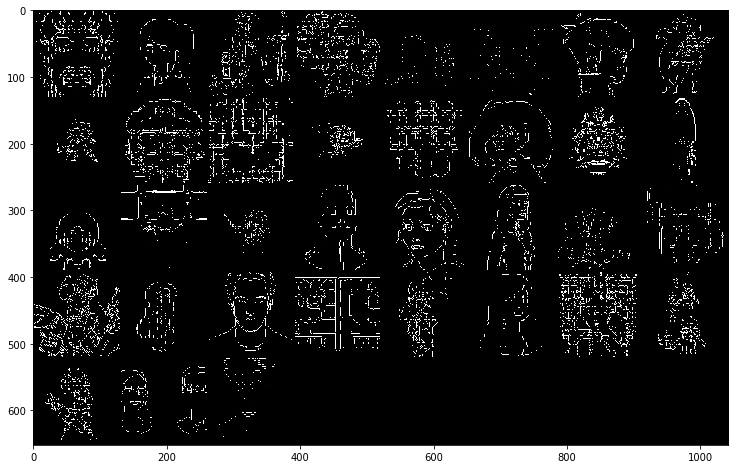

In [6]:
images, labels = trainiter_canny.next()
print(images.shape)

# show images
plt.figure(figsize=(18,8))
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([35, 3, 128, 128])


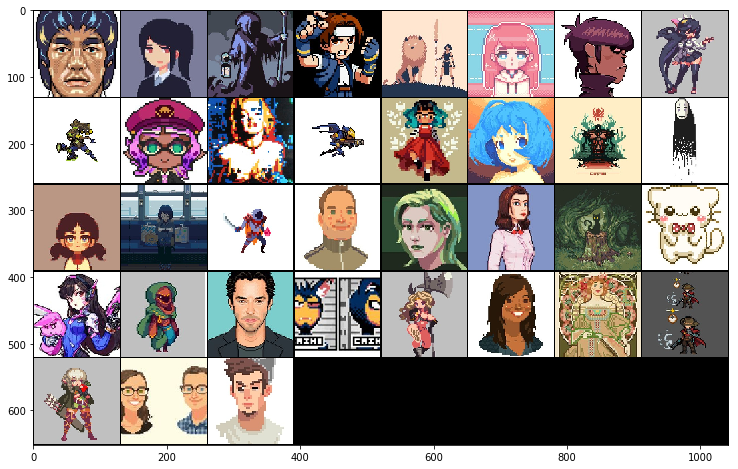

In [7]:
images, labels = trainIter_images.next()
print(images.shape)

# show images
plt.figure(figsize=(18,8))
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Selecting Optimizer 

In [8]:
criterion = nn.BCELoss().to(device)
L1_loss = nn.L1Loss().to(device)

d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Training PIX2PIX

In [9]:
#Patch Version

# Train the model
total_step = len(canny_inputloader)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 2500
sample_imflag = 0
imsize = 128

for epoch in range(num_epochs):
    
    trainiter_canny = iter(canny_inputloader)
    trainIter_images = iter(real_imageloader)
    
    for i in range(10):
        
        canny_in, _ = trainiter_canny.next()
        real_im, _ = trainIter_images.next()
        
        # Discriminator Training
        canny_in = canny_in.to(device)
        real_im = real_im.to(device)
        
#         print(canny_in.shape, real_im.shape)
        D.zero_grad()
        
        # Run the forward pass
        real_classification = D(canny_in,real_im).squeeze()        
        
        fake_images = G(canny_in)
        fake_classification = D(canny_in,fake_images).squeeze()
        
        d_loss_real = criterion(real_classification, Variable(torch.ones(real_classification.size()).cuda()))
        d_loss_fake = criterion(fake_classification, Variable(torch.zeros(fake_classification.size()).cuda()))
        d_loss = (d_loss_real + d_loss_fake)/2
        
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        # Generator Training
        
        G.zero_grad()
    
        fake_images = G(canny_in)
        fake_classification = D(fake_images,real_im).squeeze()
    
        g_loss = criterion(fake_classification, Variable(torch.ones(fake_classification.size()).cuda()))    
        con_loss = 100*L1_loss(fake_images, real_im)
        g_loss += con_loss
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
    
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, imsize, imsize)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = canny_in.view(canny_in.size(0), 3, imsize, imsize)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    
#GANs are saved
torch.save(G.state_dict(), 'GAN_OUTs/Pix2Pix_Gen.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/Pix2Pix_Dis.pkl')
    


Epoch No [10/2500] Discriminator Loss: 0.0042, Generator Loss: 21.5608
Epoch No [20/2500] Discriminator Loss: 0.0015, Generator Loss: 17.3815
Epoch No [30/2500] Discriminator Loss: 0.0009, Generator Loss: 15.2356
Epoch No [40/2500] Discriminator Loss: 0.0009, Generator Loss: 14.0627
Epoch No [50/2500] Discriminator Loss: 0.0127, Generator Loss: 11.4017
Epoch No [60/2500] Discriminator Loss: 0.2828, Generator Loss: 11.6675
Epoch No [70/2500] Discriminator Loss: 0.0019, Generator Loss: 10.0162
Epoch No [80/2500] Discriminator Loss: 0.0011, Generator Loss: 9.5567
Epoch No [90/2500] Discriminator Loss: 0.0112, Generator Loss: 9.1004
Epoch No [100/2500] Discriminator Loss: 0.0034, Generator Loss: 8.2279
Epoch No [110/2500] Discriminator Loss: 0.0101, Generator Loss: 7.9528
Epoch No [120/2500] Discriminator Loss: 0.0026, Generator Loss: 7.6537
Epoch No [130/2500] Discriminator Loss: 0.0017, Generator Loss: 7.2669
Epoch No [140/2500] Discriminator Loss: 0.0017, Generator Loss: 6.8536
Epoch No

KeyboardInterrupt: 

In [10]:
torch.save(G.state_dict(), 'GAN_OUTs/Pix2Pix_Gen.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/Pix2Pix_Dis.pkl')

In [9]:
G = generator()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G.load_state_dict(torch.load('GAN_OUTs/Pix2Pix_Gen.pkl'))
G = G.to(device)

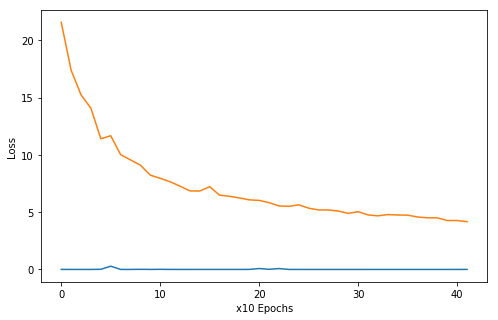

In [11]:
plt.figure(figsize=[8,5])
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.ylabel('Loss')
plt.xlabel('x10 Epochs')
plt.show()

In [10]:
path = 'CannyRealpixFlickr_500'
pixelDSlist = Picsle8DS_Tensor(path)
canny_realloader = pyD.DataLoader(pixelDSlist, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)
realiter_canny = iter(canny_realloader)

In [18]:
testImages = realiter_canny.next()
testimg = testImages[0].to(device)
print(testimg.shape)

output = G(testimg)

fake_images = output.view(output.size(0), 3, 128, 128)
f = fake_images.detach().cpu().numpy()
save_image(fake_images.data, 'images/GAN_IO/pix2pix_output.png')

testImages = testimg.view(testimg.size(0), 3, 128, 128)
t = testImages.detach().cpu().numpy()
save_image(testimg.data, 'images/GAN_IO/pix2pix_input.png')


torch.Size([32, 3, 128, 128])
